---
title: Overview of the event
---

We are using `PSP_SWP_SPI_SF00_L3_MOM` dataset

In [4]:
#| echo: false
#| output: false
from sunpy.time import TimeRange
from space_analysis.missions.psp.plasma import load_data as load_data_plasma
from space_analysis.utils.speasy import Variables
import space_analysis.missions.dscovr as dscovr

from space_analysis.plasma.formulary import df_beta, df_Alfven_speed
from space_analysis.utils.basic import resample

import polars as pl
from beforerr.polars import pl_norm

import astropy.units as u

from datetime import timedelta

In [20]:
psp_start = '2019-04-06T12:00'
psp_end = '2019-04-07T12:00'

earth_start = '2019-04-09'
earth_end = '2019-04-14'

every = timedelta(minutes=4)

In [68]:
psp_timerange = TimeRange(psp_start, psp_end)
psp_vec_cols = [f"V{_} RTN" for _ in ["x", "y", "z"]]
psp_mag_cols = [f"B{_} SC" for _ in ["x", "y", "z"]]

earth_timerange = TimeRange(earth_start, earth_end)
dscovr_vec_cols = [f"V{_} (GSE)" for _ in ["X", "Y", "Z"]]

In [22]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [27]:
dataset = "PSP_SWP_SPI_SF00_L3_MOM"
parameters = ["DENS", "VEL_RTN_SUN", "TEMP", "MAGF_SC", "SUN_DIST"]

In [28]:
psp_plasma = Variables(
    dataset=dataset, parameters=parameters, timerange=validate(psp_timerange)
).get_data()

In [29]:
psp_plasma.preview()

Density,time,Vx RTN,Vy RTN,Vz RTN,Temperature,Bx SC,By SC,Bz SC,Sun Distance
f64,datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64
125.896805,2019-04-06 12:00:01.807751680,279.013275,-22.078077,-13.357628,24.181284,8.822601,0.461628,92.034622,2.6128e7
126.359596,2019-04-06 12:00:08.798291968,277.421265,-21.862406,-13.040775,23.229742,8.355888,-0.51781,91.786186,2.6129e7
126.038277,2019-04-06 12:00:15.788832384,278.90918,-20.868137,-16.348549,24.575506,9.533891,2.161394,91.447662,2.6129e7
126.396591,2019-04-06 12:00:22.779372928,278.448761,-21.389915,-15.307798,24.457956,9.025012,0.926288,91.391006,2.6129e7
124.861832,2019-04-06 12:00:29.769853312,278.025299,-19.937567,-16.487917,23.808815,10.204762,2.401658,91.301651,2.6129e7


In [43]:
dscovr_mag = Variables(
    products=["cda/DSCOVR_H0_MAG/B1F1"], timerange=validate(earth_timerange)
).get_data()

In [56]:
dscovr_plasma = Variables(
    dataset="DSCOVR_H1_FC",
    parameters=["Np", "V_GSE", "THERMAL_TEMP"],
    timerange=validate(earth_timerange),
).get_data()

In [63]:
dscovr_mag.preview()

B,time
f64,datetime[ns]
5.301406,2019-04-09 00:00:00.500
5.253167,2019-04-09 00:00:01.500
5.261587,2019-04-09 00:00:02.500
5.331752,2019-04-09 00:00:03.500
5.379873,2019-04-09 00:00:04.500


## Radial evolution of the coronal hole high-speed streams

@perroneRadialEvolutionSolar2019 used HELIOS observations to study the radial evolution of the solar wind in coronal hole high-speed streams. They found that The radial dependence of the proton number density, np, and the magnetic field, B, is given by

The radial dependence of the proton number density, np is

$$n_p = (2.4 ± 0.1)(R/R_0)^{−(1.96±0.07)} cm^{−3}$$

$$B = (5.7 ± 0.2)(R/R_0)^{−(1.59±0.06)} nT$$

The faster decrease of the magnetic than kinetic pressure is reﬂected in the radial proton plasma beta variation

$$β_p = P_k/P_B = (0.55 ± 0.04)(R/R_0)^{(0.4±0.1)}.$$

The behaviour of the parallel proton plasma beta is similar 

$$β_{‖} = (0.37 ± 0.03)(R/R_0)^{(0.8±0.1)}$$

In [13]:
def plasma_r_evolution(
    df: pl.DataFrame,
    alpha_beta_r = 0.4,
    alpha_beta_parallel_r = 0.9,
    alpha_n = -2,
    alpha_B = -1.63,
    alpha_plasma_speed = 0,
):
    return df.with_columns(
        plasma_speed_1AU = pl.col('plasma_speed') * (1 / pl.col("distance2sun"))**alpha_plasma_speed,
        n_1AU = pl.col('n') * (1 / pl.col("distance2sun"))**alpha_n,
        B_1AU = pl.col('B') * (1 / pl.col("distance2sun"))**alpha_B,
        beta_1AU = pl.col("beta") * (1 / pl.col("distance2sun"))**alpha_beta_r,
        beta_parallel = pl.col("beta") * (1 / pl.col("distance2sun"))**alpha_beta_parallel_r,
    )

In [14]:
km2au = u.km.to(u.AU)

In [69]:
dscovr_df = (
    dscovr_plasma.to_polars().pipe(resample, every)
    .sort("time")
    .join_asof(dscovr_mag.to_polars().pipe(resample, every).sort("time"), on="time")
    .with_columns(
        plasma_speed=pl_norm(dscovr_vec_cols),
    )
    .rename(
        {   
            "Ion N": "n",
            "Temperature": "T",
        }
    )
    .collect()
    .pipe(df_beta, T_unit = u.K)
    .pipe(df_Alfven_speed)
    .with_columns(
        plasma_speed_over_Alfven_speed=pl.col("plasma_speed") / pl.col("Alfven_speed"),
    )
)

In [73]:
psp_plasma_r = (
    psp_plasma.to_polars().pipe(resample, every)
    .with_columns(
        B=pl_norm(psp_mag_cols),
        plasma_speed = pl_norm(psp_vec_cols),
        distance2sun = pl.col('Sun Distance') * km2au,
    )
    .rename(
        {
            "Density": "n",
            "Temperature": "T",
        }
    )
    .collect()
    .pipe(df_beta)
    .pipe(plasma_r_evolution)
    .pipe(df_Alfven_speed)
    .pipe(df_Alfven_speed, B = "B_1AU", n = "n_1AU", col_name = "Alfven_speed_1AU")
    .with_columns(
        plasma_speed_over_Alfven_speed = pl.col("plasma_speed") / pl.col("Alfven_speed"),
        plasma_speed_over_Alfven_speed_1AU = pl.col("plasma_speed_1AU") / pl.col("Alfven_speed_1AU"),
    )
)

In [74]:
plot = psp_plasma_r.plot(x="time", y=["plasma_speed", "beta", "Alfven_speed", "plasma_speed_over_Alfven_speed"], subplots=True, shared_axes=False).cols(1)

plot_1AU = psp_plasma_r.plot(x="time", y=["plasma_speed_1AU", "beta_1AU", "Alfven_speed_1AU", "plasma_speed_over_Alfven_speed_1AU"], subplots=True, shared_axes=False).cols(1)

plot + plot_1AU

:Layout
   .NdLayout.I  :NdLayout   [Variable]
      :Curve   [time]   (value)
   .NdLayout.II :NdLayout   [Variable]
      :Curve   [time]   (value)

In [76]:
import hvplot.polars  # noqa

hvplot.extension('matplotlib')

:Overlay
   .Scatter.PSP                                                  :Scatter   [beta]   (plasma_speed_over_Alfven_speed)
   .Scatter.PSP_left_parenthesis_1AU_predicted_right_parenthesis :Scatter   [beta_1AU]   (plasma_speed_over_Alfven_speed_1AU)
   .Scatter.DSCOVR                                               :Scatter   [beta]   (plasma_speed_over_Alfven_speed)
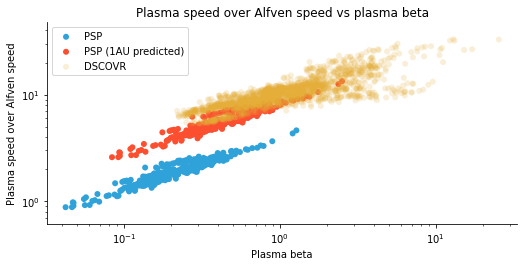

In [92]:
psp_plasma_r.plot.scatter(
    x="beta", y="plasma_speed_over_Alfven_speed", logx=True, logy=True, label='PSP'
) * psp_plasma_r.plot.scatter(
    x="beta_1AU", y="plasma_speed_over_Alfven_speed_1AU", logx=True, logy=True, label='PSP (1AU predicted)', alpha=0.5
) * dscovr_df.plot.scatter(
    x="beta", y="plasma_speed_over_Alfven_speed", logx=True, logy=True, label='DSCOVR', alpha=0.2
).opts(title="Plasma speed over Alfven speed vs plasma beta", xlabel="Plasma beta", ylabel="Plasma speed over Alfven speed")